# Test 3: Spectered Embeddings Variant and Ablation (Weighting, Cleaning, and Robustness Checks)

This notebook extends Test 1 with principled variants to isolate why spectering helps or hurts. This is to be able to attribute it to a specific choice (weight schedule, minimum weight cutoff, anchor selection, token cleaning).


In [1]:
# If you run this in a fresh environment, uncomment:
# %pip install -q numpy pandas matplotlib scipy gensim tqdm


In [2]:
from pathlib import Path
import re, glob, pickle
from typing import Dict, List, Tuple, Optional, Callable, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes
from gensim.models import KeyedVectors

pd.set_option("display.max_colwidth", 180)


## 0) Config 

In [ ]:
# -----------------------------
# Paths
# -----------------------------
THESIS_ROOT = Path(r"G:/My Drive/ThesisMaterial")
LOCAL_W2V_DIR = THESIS_ROOT / "Computation" / "models" / "word2vecDecade"
SGNS_DIR      = THESIS_ROOT / "Computation" / "data" / "sgns"

# -----------------------------
# Token cleaning (neighbor display + anchor selection)
# Tweak these if your corpus has different tokenization.
# -----------------------------
TOKEN_MIN_LEN = 3

# Drop digits, roman numerals, and heavy punctuation/noise.
RE_ROMAN = re.compile(r"^[ivxlcdm]+$", re.IGNORECASE)
RE_HAS_DIGIT = re.compile(r"\d")
RE_BAD_PUNCT = re.compile(r"[^a-zA-Z\-']")   # allow letters, hyphen, apostrophe
RE_MULTI_HYPHEN = re.compile(r"-{2,}")

def is_good_token(w: str) -> bool:
    if w is None:
        return False
    w = w.strip()
    if len(w) < TOKEN_MIN_LEN:
        return False
    if RE_HAS_DIGIT.search(w):
        return False
    if RE_ROMAN.match(w):
        return False
    if RE_MULTI_HYPHEN.search(w):
        return False
    # reject tokens with characters outside [A-Za-z-']
    if RE_BAD_PUNCT.search(w):
        return False
    # avoid leading/trailing hyphen
    if w.startswith("-") or w.endswith("-"):
        return False
    return True

# -----------------------------
# Experiment term sets (edit freely)
# -----------------------------
TERM_SETS = {
    "sanity_common": ["man","woman","child","house","room","work","money","horse"],
    "plantation_core": ["plantation","slave","master","cotton"],
    "your_current": ["freedom","master","slave","cotton","negro"],
}

ACTIVE_TERM_SET = "your_current"   
TARGET_WORDS = TERM_SETS[ACTIVE_TERM_SET]

# -----------------------------
# Specter parameters (edit)
# -----------------------------
# Exponential decay weights are: wt = alpha^(steps_back)
# A more intuitive way to set alpha is via a half-life in *decades*:
#   after HALF_LIFE_DECADES, the weight is halved.
WEIGHTING_SCHEME = "exponential_decay"  # exponential_decay | uniform | recency_bias

HALF_LIFE_DECADES = 3  
ALPHA = float(0.5 ** (1.0 / HALF_LIFE_DECADES))  # derived from half-life

# Drop extremely tiny weights so very old decades don't add numerical noise
MIN_WEIGHT = 0.01

print("Specter config:", "scheme=", WEIGHTING_SCHEME, "| half_life=", HALF_LIFE_DECADES,
      "| alpha=", round(ALPHA, 6), "| min_weight=", MIN_WEIGHT)

# -----------------------------
# Alignment parameters (edit)
# ----------------------------- (edit)
# -----------------------------
N_ANCHORS = 2000         # key change: use a big anchor set
ANCHOR_RANDOM_SEED = 7


Specter config: scheme= exponential_decay | half_life= 3 | alpha= 0.793701 | min_weight= 0.01


## 1) Loaders + alignment helpers 

In [4]:
def normalize_rows(W: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    W = W.astype(np.float32, copy=False)
    norms = np.linalg.norm(W, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return W / norms

def list_local_w2v_buckets(local_dir: Path) -> List[int]:
    if not local_dir.exists():
        return []
    decades = []
    for p in local_dir.glob("word2vec_*.w2v"):
        m = re.search(r"word2vec_(\d{4})_(\d{4})\.w2v$", p.name)
        if m:
            decades.append(int(m.group(1)))
    return sorted(set(decades))

def load_word2vec_any_format(path: Path) -> Tuple[KeyedVectors, Dict[str, bool]]:
    """Try common word2vec variants (text/binary, with/without header)."""
    errors = []
    for binary in (False, True):
        for no_header in (False, True):
            try:
                kv = KeyedVectors.load_word2vec_format(
                    str(path),
                    binary=binary,
                    no_header=no_header,
                )
                return kv, {"binary": binary, "no_header": no_header}
            except Exception as e:
                errors.append((binary, no_header, repr(e)))
    msg = "Failed to load word2vec vectors in any expected format.\n"
    msg += f"Path: {path}\n"
    msg += "Tried (binary, no_header):\n" + "\n".join([f"  {b}, {h} -> {err}" for b, h, err in errors[:8]])
    raise RuntimeError(msg)

def load_local_w2v_decade(decade: int, local_dir: Path) -> Tuple[np.ndarray, List[str], Dict[str,int]]:
    candidates = sorted(local_dir.glob(f"word2vec_{decade}_*.w2v"))
    if not candidates:
        raise FileNotFoundError(f"No .w2v found for decade start {decade} in {local_dir}")
    kv, fmt = load_word2vec_any_format(candidates[0])
    print(f"Loaded local W2V {candidates[0].name} with format {fmt}")
    vocab = list(kv.index_to_key)
    W = normalize_rows(kv.vectors)
    w2i = {w:i for i,w in enumerate(vocab)}
    return W, vocab, w2i

def _find_file_for_decade(directory: Path, decade: int, exts: Tuple[str,...]) -> Optional[Path]:
    pats = [str(directory / f"*{decade}*{ext}") for ext in exts]
    hits = []
    for pat in pats:
        hits.extend([Path(p) for p in glob.glob(pat)])
    hits = sorted(hits, key=lambda p: (len(p.name), p.name))
    return hits[0] if hits else None

def list_sgns_decades(sgns_dir: Path) -> List[int]:
    if not sgns_dir.exists():
        return []
    decades = set()
    for p in sgns_dir.glob("*.npy"):
        m = re.search(r"(\d{4})", p.name)
        if m:
            y = int(m.group(1))
            if y % 10 == 0:
                decades.add(y)
    return sorted(decades)

def load_sgns_decade(decade: int, sgns_dir: Path) -> Tuple[np.ndarray, List[str], Dict[str,int]]:
    w_path = _find_file_for_decade(sgns_dir, decade, (".npy",))
    v_path = _find_file_for_decade(sgns_dir, decade, (".pkl", ".pickle"))
    if w_path is None or v_path is None:
        raise FileNotFoundError(f"Missing SGNS files for {decade} in {sgns_dir} (need .npy + vocab .pkl)")
    W = normalize_rows(np.load(str(w_path)))
    with open(v_path, "rb") as f:
        vocab = list(pickle.load(f))
    if len(vocab) != W.shape[0]:
        raise ValueError(f"{decade}: vocab length {len(vocab)} != W rows {W.shape[0]} for {w_path.name}")
    w2i = {w:i for i,w in enumerate(vocab)}
    return W, vocab, w2i

def build_alignment(load_fn: Callable[[int], Tuple[np.ndarray, List[str], Dict[str,int]]],
                    decades: List[int],
                    ref_decade: int,
                    stable_words: List[str]) -> Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]]:
    """Align every decade to ref_decade via orthogonal Procrustes on shared stable anchors."""
    W_ref, vocab_ref, w2i_ref = load_fn(ref_decade)
    anchors = [w for w in stable_words if w in w2i_ref]
    if len(anchors) < 8:
        raise RuntimeError(f"Too few anchors present in reference decade {ref_decade}: {len(anchors)}")

    aligned = {}
    for d in decades:
        W, vocab, w2i = load_fn(d)
        shared = [w for w in anchors if w in w2i]
        if len(shared) < 8:
            continue

        idx_d   = np.array([w2i[w] for w in shared], dtype=int)
        idx_ref = np.array([w2i_ref[w] for w in shared], dtype=int)

        A_d   = W[idx_d]
        A_ref = W_ref[idx_ref]

        R, _ = orthogonal_procrustes(A_d, A_ref)
        W_aligned = normalize_rows(W @ R)

        aligned[d] = (W_aligned, vocab, w2i)
    return aligned


## 2) anchor selection 

In [5]:
def build_large_intersection_anchors(
    load_fn: Callable[[int], Tuple[np.ndarray, List[str], Dict[str,int]]],
    decades: List[int],
    ref_decade: int,
    n_anchors: int = 2000,
    seed: int = 7,
) -> List[str]:
    """
    Build a large anchor list by taking the intersection vocab across all decades,
    cleaning tokens, then sampling up to n_anchors.
    """
    _, vocab_ref, _ = load_fn(ref_decade)
    inter: Set[str] = set([w for w in vocab_ref if is_good_token(w)])

    for d in decades:
        _, vocab, _ = load_fn(d)
        inter &= set([w for w in vocab if is_good_token(w)])
        if len(inter) == 0:
            break

    inter = sorted(inter)
    if not inter:
        raise RuntimeError("Intersection anchors are empty after cleaning. Relax is_good_token() or TOKEN_MIN_LEN.")

    rng = np.random.default_rng(seed)
    if len(inter) > n_anchors:
        idx = rng.choice(len(inter), size=n_anchors, replace=False)
        anchors = [inter[i] for i in idx]
    else:
        anchors = inter

    return anchors

def describe_vocab_noise(vocab: List[str], n: int = 30) -> pd.DataFrame:
    samp = vocab[: min(len(vocab), 5000)]
    good = [w for w in samp if is_good_token(w)]
    bad = [w for w in samp if not is_good_token(w)]
    return pd.DataFrame({
        "sample_size": [len(samp)],
        "good_tokens": [len(good)],
        "bad_tokens": [len(bad)],
        "bad_rate": [len(bad) / max(1, len(samp))],
        "example_bad": [", ".join(bad[:n])]
    })


## 3) Discover decades + build aligned baselines

In [6]:
local_decades = list_local_w2v_buckets(LOCAL_W2V_DIR)
sgns_decades  = list_sgns_decades(SGNS_DIR)

candidate_common = sorted(set(local_decades) & set(sgns_decades))
if not candidate_common:
    raise RuntimeError("No overlapping decades found between LOCAL_W2V_DIR and SGNS_DIR.")

def load_local(d: int):
    return load_local_w2v_decade(d, LOCAL_W2V_DIR)

def load_sgns(d: int):
    return load_sgns_decade(d, SGNS_DIR)

def decade_loads(load_fn, d: int) -> bool:
    try:
        load_fn(d)
        return True
    except Exception as e:
        print(f"Skipping decade {d}: failed to load -> {e}")
        return False

# Keep only decades that successfully load in BOTH embedding families
COMMON_DECADES = [d for d in candidate_common if decade_loads(load_local, d) and decade_loads(load_sgns, d)]
if not COMMON_DECADES:
    raise RuntimeError("Overlapping decades exist, but none of the overlapping decade files successfully load.")

REF_DECADE = COMMON_DECADES[-1]

print("COMMON_DECADES:", COMMON_DECADES)
print("REF_DECADE:", REF_DECADE)

# Quick noise check on the reference decade
_, vocab_local_ref, _ = load_local(REF_DECADE)
_, vocab_sgns_ref,  _ = load_sgns(REF_DECADE)
display(describe_vocab_noise(vocab_local_ref))
display(describe_vocab_noise(vocab_sgns_ref))

# Build big anchors separately per embedding family
anchors_local = build_large_intersection_anchors(load_local, COMMON_DECADES, REF_DECADE, n_anchors=N_ANCHORS, seed=ANCHOR_RANDOM_SEED)
anchors_sgns  = build_large_intersection_anchors(load_sgns,  COMMON_DECADES, REF_DECADE, n_anchors=N_ANCHORS, seed=ANCHOR_RANDOM_SEED)

print("anchors_local:", len(anchors_local))
print("anchors_sgns :", len(anchors_sgns))

# Align
w2v_aligned  = build_alignment(load_local, COMMON_DECADES, REF_DECADE, anchors_local)
sgns_aligned = build_alignment(load_sgns,  COMMON_DECADES, REF_DECADE, anchors_sgns)

print("Aligned W2V decades:", sorted(w2v_aligned.keys()))
print("Aligned SGNS decades:", sorted(sgns_aligned.keys()))


Loaded local W2V word2vec_1830_1839.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1840_1849.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1850_1859.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1860_1869.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1870_1879.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1880_1889.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1890_1899.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1900_1912.w2v with format {'binary': False, 'no_header': False}
COMMON_DECADES: [1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900]
REF_DECADE: 1900
Loaded local W2V word2vec_1900_1912.w2v with format {'binary': False, 'no_header': False}


,sample_size,good_tokens,bad_tokens,bad_rate,example_bad
0,5000,4851,149,0.0298,"to, of, a, he, i, in, it, as, an, on, at, is, be, de, me, by, do, my, so, no, up, if, did, we, or, go, er, oh, o, am"


,sample_size,good_tokens,bad_tokens,bad_rate,example_bad
0,5000,4878,122,0.0244,"of, to, in, a, is, it, be, as, he, i, by, on, at, or, we, an, so, if, no, my, do, me, up, did, us, go, am, 1, de, 2"


Loaded local W2V word2vec_1900_1912.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1830_1839.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1840_1849.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1850_1859.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1860_1869.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1870_1879.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1880_1889.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1890_1899.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1900_1912.w2v with format {'binary': False, 'no_header': False}
anchors_local: 2000
anchors_sgns : 2000
Loaded local W2V word2vec_1900_1912.w2v with format {'binary': False, 'no_header': False}
Loaded local W2V word2vec_1830_1839.w2v with format {'binary

## 4) Alignment stability

In [7]:
def anchor_alignment_report(aligned: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]],
                            ref_decade: int,
                            anchors: List[str]) -> pd.DataFrame:
    W_ref, _, w2i_ref = aligned[ref_decade]
    rows = []
    for d,(W,_,w2i) in sorted(aligned.items()):
        shared = [w for w in anchors if (w in w2i and w in w2i_ref)]
        if len(shared) < 200:
            continue
        idx_d = np.array([w2i[w] for w in shared], dtype=int)
        idx_r = np.array([w2i_ref[w] for w in shared], dtype=int)
        sims = np.sum(W[idx_d] * W_ref[idx_r], axis=1)
        rows.append({
            "decade": d,
            "n_shared": len(shared),
            "anchor_cos_mean_to_ref": float(np.mean(sims)),
            "anchor_cos_std_to_ref": float(np.std(sims)),
            "anchor_cos_p10_to_ref": float(np.quantile(sims, 0.10)),
            "anchor_cos_p90_to_ref": float(np.quantile(sims, 0.90)),
        })
    return pd.DataFrame(rows)

display(anchor_alignment_report(w2v_aligned,  REF_DECADE, anchors_local))
display(anchor_alignment_report(sgns_aligned, REF_DECADE, anchors_sgns))


,decade,n_shared,anchor_cos_mean_to_ref,anchor_cos_std_to_ref,anchor_cos_p10_to_ref,anchor_cos_p90_to_ref
0,1830,2000,0.606885,1.034245e-01,0.487887,0.751502
1,1840,2000,0.613802,1.085239e-01,0.489306,0.764629
2,1850,2000,0.567626,8.574303e-02,0.470970,0.672761
3,1860,2000,0.576145,8.594336e-02,0.476999,0.686406
4,1870,2000,0.600416,1.016380e-01,0.486720,0.735444
5,1880,2000,0.583735,9.393584e-02,0.474564,0.705985
6,1890,2000,0.571355,9.200789e-02,0.468589,0.692759
7,1900,2000,1.000000,8.354224e-08,1.000000,1.000000


,decade,n_shared,anchor_cos_mean_to_ref,anchor_cos_std_to_ref,anchor_cos_p10_to_ref,anchor_cos_p90_to_ref
0,1830,2000,0.163574,0.314456,0.0,0.773718
1,1840,2000,0.177712,0.320434,0.0,0.764580
2,1850,2000,0.208218,0.327360,0.0,0.745351
3,1860,2000,0.195892,0.326441,0.0,0.758491
4,1870,2000,0.210976,0.330599,0.0,0.751614
5,1880,2000,0.240943,0.337123,0.0,0.745911
6,1890,2000,0.259970,0.337858,0.0,0.744133
7,1900,2000,0.425500,0.494419,0.0,1.000000


## 5) Spectered embeddings 

In [8]:
def load_spectered_from_aligned(
    aligned: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]],
    decades_ordered: List[int],
    weighting_scheme: str = "exponential_decay",
    alpha: float = 0.7,
    min_weight: float = 0.05,
) -> Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]]:
    decades_ordered = [d for d in decades_ordered if d in aligned]
    if not decades_ordered:
        raise RuntimeError("No decades available in aligned dict for spectering.")

    spectered = {}
    for i, cur_dec in enumerate(decades_ordered):
        W_cur, vocab_cur, w2i_cur = aligned[cur_dec]
        W_spec = np.zeros_like(W_cur)

        if weighting_scheme == "recency_bias":
            denom = (i + 1) * (i + 2) / 2.0

        for word in vocab_cur:
            idx_cur = w2i_cur[word]
            past_vecs = []
            past_wts = []

            for j in range(i + 1):
                past_dec = decades_ordered[j]
                W_p, _, w2i_p = aligned[past_dec]
                if word not in w2i_p:
                    continue

                steps_back = i - j
                if weighting_scheme == "exponential_decay":
                    wt = alpha ** steps_back
                elif weighting_scheme == "uniform":
                    wt = 1.0
                elif weighting_scheme == "recency_bias":
                    wt = (j + 1) / denom
                else:
                    raise ValueError(f"Unknown weighting_scheme: {weighting_scheme}")

                if wt < min_weight:
                    continue

                past_vecs.append(W_p[w2i_p[word]])
                past_wts.append(wt)

            if past_vecs:
                wts = np.array(past_wts, dtype=np.float32)
                wts /= wts.sum()
                W_spec[idx_cur] = np.average(np.vstack(past_vecs), axis=0, weights=wts)
            else:
                W_spec[idx_cur] = W_cur[idx_cur]

        spectered[cur_dec] = (normalize_rows(W_spec), vocab_cur, w2i_cur)

    return spectered

DECADES_ORDERED = sorted(w2v_aligned.keys())

w2v_spectered = load_spectered_from_aligned(
    w2v_aligned, DECADES_ORDERED,
    weighting_scheme=WEIGHTING_SCHEME, alpha=ALPHA, min_weight=MIN_WEIGHT
)
sgns_spectered = load_spectered_from_aligned(
    sgns_aligned, DECADES_ORDERED,
    weighting_scheme=WEIGHTING_SCHEME, alpha=ALPHA, min_weight=MIN_WEIGHT
)

print("TARGET_WORDS:", TARGET_WORDS)
print("Specter params:", WEIGHTING_SCHEME, "alpha=", ALPHA, "min_weight=", MIN_WEIGHT)


TARGET_WORDS: ['freedom', 'master', 'slave', 'cotton', 'negro']
Specter params: exponential_decay alpha= 0.7937005259840998 min_weight= 0.01


## 6) Evaluation utilities 

In [9]:
def topk_neighbors(W: np.ndarray, vocab: List[str], w2i: Dict[str,int], term: str, k: int = 25) -> List[Tuple[str, float]]:
    if term not in w2i:
        return []
    i = w2i[term]
    v = W[i]
    sims = W @ v
    sims[i] = -np.inf
    idx = np.argpartition(sims, -k)[-k:]
    idx = idx[np.argsort(-sims[idx])]
    return [(vocab[j], float(sims[j])) for j in idx]

def clean_neighbors(neigh: List[Tuple[str, float]], keep_k: int = 12) -> List[Tuple[str, float]]:
    out = []
    for w,s in neigh:
        if is_good_token(w):
            out.append((w,s))
        if len(out) >= keep_k:
            break
    return out

def neighbor_trail(term: str,
                   emb: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]],
                   k: int = 75,
                   keep_k: int = 12) -> pd.DataFrame:
    rows = []
    for d,(W,vocab,w2i) in sorted(emb.items()):
        nbs = clean_neighbors(topk_neighbors(W, vocab, w2i, term, k=k), keep_k=keep_k)
        rows.append({"decade": d, "neighbors": ", ".join([w for w,_ in nbs])})
    return pd.DataFrame(rows)

def neighbor_overlap(term: str,
                     emb: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]],
                     k: int = 100,
                     keep_k: int = 25) -> pd.DataFrame:
    decades = sorted(emb.keys())
    prev_set = None
    prev_dec = None
    rows = []
    for d in decades:
        W,vocab,w2i = emb[d]
        nbs = clean_neighbors(topk_neighbors(W, vocab, w2i, term, k=k), keep_k=keep_k)
        cur_set = set([w for w,_ in nbs])
        if prev_set is not None:
            inter = len(cur_set & prev_set)
            union = len(cur_set | prev_set) or 1
            rows.append({"decade": d, "prev_decade": prev_dec, "jaccard": inter/union})
        prev_set, prev_dec = cur_set, d
    return pd.DataFrame(rows)

def adjacent_change(term: str, emb: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]]) -> pd.DataFrame:
    decades = sorted(emb.keys())
    rows = []
    prev_vec = None
    prev_dec = None
    for d in decades:
        W, _, w2i = emb[d]
        if term not in w2i:
            prev_vec, prev_dec = None, None
            continue
        v = W[w2i[term]]
        if prev_vec is not None:
            cos = float(v @ prev_vec)
            rows.append({"decade": d, "prev_decade": prev_dec, "cos_to_prev": cos, "change": 1.0 - cos})
        prev_vec, prev_dec = v, d
    return pd.DataFrame(rows)

def plot_two_series(df_a: pd.DataFrame, df_b: pd.DataFrame, x: str, y: str, label_a: str, label_b: str, title: str):
    plt.figure()
    if not df_a.empty:
        plt.plot(df_a[x], df_a[y], marker="o", label=label_a)
    if not df_b.empty:
        plt.plot(df_b[x], df_b[y], marker="o", label=label_b)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()


## 7) Run: neighbors + overlap + drift 


TERM: freedom

W2V baseline neighbors (clean)


,decade,neighbors
0,1830,"stares, democracy, incendiary, venus, slaveholders, assistant, abolitionist, dual, insisting, oxen, contingency, handmaid"
1,1840,"thick-set, trysting-places, grandest, mart, deceptive, oppression, wearied, tyrants, yoke, ban, hissed, strand"
2,1850,"sober-minded, signet, field-laborer, trickery, bad-looking, hollar, assassinated, jural, plantashun, yov, strictness, discountenanced"
3,1860,"tyrannously, dom, leadenhall, man-servant, reflectively, appro, inspires, initiatively, theorists, pocketing, bothered, bined"
4,1870,"self-awakened, beneficence, sympathise, pro-slavery, beneficial, reversing, shackled, defect, proportionably, spicion, environs, fection"
5,1880,"niek, realizes, harborin, trample, arly, gibus, secede, remedies, ported, oncet, sovereignty, estimated"
6,1890,"simian, coquetr, bigotries, avagons, onybody, dowu, worthlessness, cerements, brunt, dinner-bugle, barbarisms, girding"
7,1900,"rosemary, plantain, deuced, splease, fathomed, freer, yerbs, spah, reptile, hog-feeder, minnows, indecency"



W2V spectered neighbors (clean)


,decade,neighbors
0,1830,"stares, democracy, incendiary, venus, slaveholders, assistant, abolitionist, dual, insisting, oxen, contingency, handmaid"
1,1840,"degradation, tyrants, oppression, inculcated, rooted, inquietude, hazarded, passive, subserviency, usurped, compulsion, hissed"
2,1850,"inquietude, overthrow, slaveholding, hazarded, retard, emufa, ishmael, tyrants, tyrannize, galling, slave-dealer, pro-slavery"
3,1860,"accruing, emancipating, enslaved, man-servant, calamities, escutcheon, vilify, slaveholder, perdition, determines, tyrants, fanatics"
4,1870,"tyrants, slaveholder, pro-slavery, equality, fellow-beings, aro, proportionably, liberation, misrepresentations, abolished, slave-holding, sully"
5,1880,"fanatics, liberation, equality, slaveholder, secede, slave-holders, governmental, tyrants, regeneration, educate, arrogance, fellow-beings"
6,1890,"simian, sophistries, liberation, slaveholder, slave-holder, scoundrels, obloquy, repudiate, healthily, murdering, forfeited, fanatics"
7,1900,"performs, slaveholders, slave-holding, debarred, intellects, millennium, treasonable, wield, forfeited, practices, faithfulness, stoned"


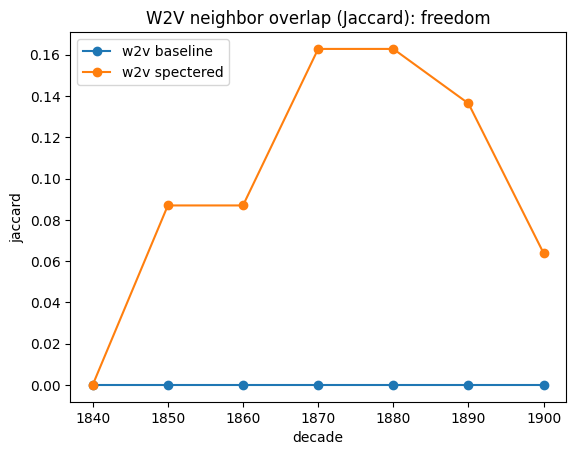

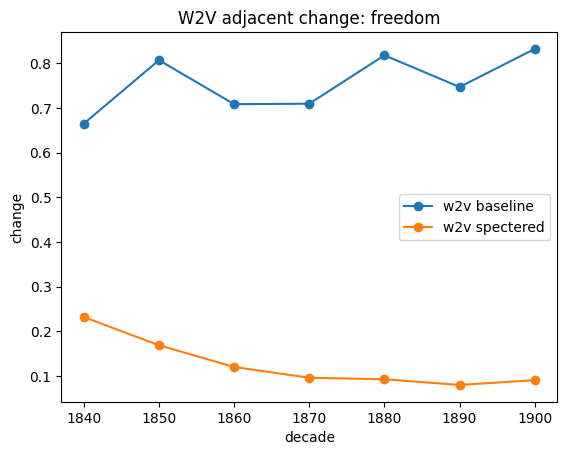


TERM: master

W2V baseline neighbors (clean)


,decade,neighbors
0,1830,"prophecy, ifke, brisker, wilh, inslance, incoherence, junol, alf, grimace, prerogatives, reclaimed, fellow-countrymen"
1,1840,"kidnapped, hardness, whippings, inarticulate, self-defence, unfeeling, tasks, insubordination, enhance, resource, poplar-grove, injuries"
2,1850,"slackening, rosined, lappel, curis, honeycomb, halloed, impas, smel, larned, ironical, baltimo, spcakin"
3,1860,"fence-post, iliggs, suddant, pendence, ancesters, bugbear, horse-killers, lives-all, wlion, whimpering, bob-tailed, sriore"
4,1870,"promonitaries, worker, gesticulative, mothing, forgbt, schoonermen, devoutest, spout, tax, bag-pipe, jackace, cringing"
5,1880,"cnsbiche, bouncing, deep-rooted, redolence, bastets, canons, scholah, foreknowledge, rubserved, correspondingly, desecrate, to-mo"
6,1890,"barbecued, merrimac, unhitch, harvus, borston, scalped, spare-ribs, conditionally, cootah, window-curtains, faginia, somersets"
7,1900,"economize, ingratiating, unaccounted-for, helter-skelter, rick, discrepancies, moah, layfyig, thrusting, whyfor, emphasizing, ptittin"



W2V spectered neighbors (clean)


,decade,neighbors
0,1830,"prophecy, ifke, brisker, wilh, inslance, incoherence, junol, alf, grimace, prerogatives, reclaimed, fellow-countrymen"
1,1840,"self-defence, jeers, inarticulate, hardness, poplar-grove, overhearing, disobey, thorough, flog, whippings, temporal, wonderfully"
2,1850,"undone, flog, inarticulate, curis, teasing, ransom, suspiciouslooking, baltimo, aggravating, jade, slackening, disowns"
3,1860,"flog, pic, aggravating, task-massa, ebbery, uld, soberness, iliggs, left-hand, hinc, healed, spects"
4,1870,"whipped, knowingly, promonitaries, hangman, mothing, pic, interrogator, spicious, sulkily, brutally, thieves, flog"
5,1880,"ctivity, whipped, overseer, ityal, self-appreciative, slave-trader, unbuttoning, correspondingly, redolence, knowingly, flog, thunderstruck"
6,1890,"fellow-servants, interrogator, healed, unbuttoning, sare, csesar, barbecued, schoolmaster, wisjies, sold-ier, splitting, paidyt"
7,1900,"ingratiating, ptittin, unaccounted-for, telegraphed, grey-headed, layfyig, trainer, whyfor, rick, napping, ante-room, a-sottin"


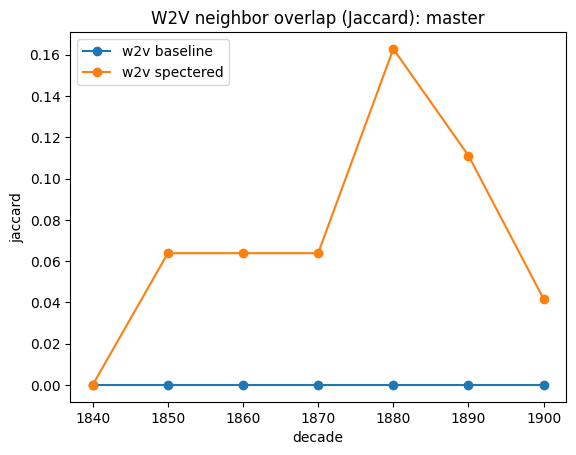

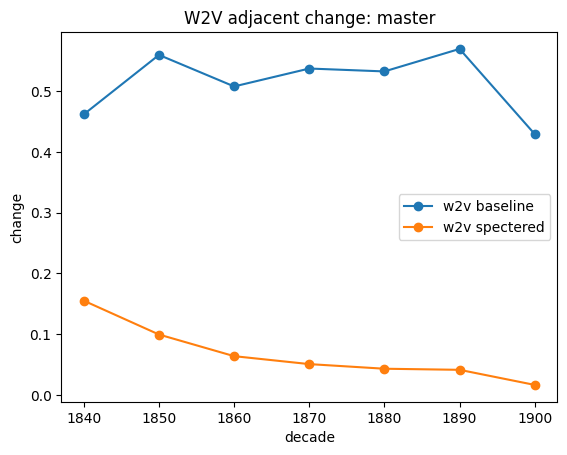


TERM: slave

W2V baseline neighbors (clean)


,decade,neighbors
0,1830,"fences, true-born, superabundance, noir, jury, rudiments, labor, inferiors, brotherly, temporal, ownership, freeman"
1,1840,"slaves, extinction, accidental, separation, unfeeling, gainers, cruelties, merited, cell, professes, pounded, dangers"
2,1850,"rag-pole, nojth, rough-shod, kij, jeopardize, jer, abideth, calqrea, celtic, operating, agrarian, editorials"
3,1860,"fpftiti, anid, hmotives, ikdukapolid, scemed, onerous, tranokr, ie-r, andit, flart, asiikr, moralize"
4,1870,"pendent, twar, fadder, boundless, necessitated, somewhar, frien, biz, cullud, unravels, eberybody, tought"
5,1880,"accumulations, degrade, sisted, averments, demurrer, apprehend, enactment, whipping-post, subtlest, half-dollar, codes, inchoate"
6,1890,"sior, zhc, barbee, cui, ffaitbful, confines, tory, mayflower, agents, sugar-cane, transcends, tear-compelling"
7,1900,"sponging, compulsory, worldold, greeks, humbler, child-wise, thirtyseven, multiplies, eras, disinterested, potency, diffidence"



W2V spectered neighbors (clean)


,decade,neighbors
0,1830,"fences, true-born, superabundance, noir, jury, rudiments, labor, inferiors, brotherly, temporal, ownership, freeman"
1,1840,"torture, freeman, extinction, slaves, poplar-grove, honorable, oppressions, outrages, servitude, slaveholder, openly, temporal"
2,1850,"slave-ship, slave-dealer, oppressions, slaveholder, slave-holders, extinction, humane, emufa, legislating, celtic, laboring, rag-pole"
3,1860,"slaveholder, emancipating, uphold, perpetrated, slave-holders, murders, educate, slave-ship, fellow-men, extinction, infanticide, carolinians"
4,1870,"tyrants, slaves, slave-holding, slaveholder, law-abiding, murders, exhort, slave-holder, educate, insufficient, slave-holders, liberation"
5,1880,"degrade, slaves, liberation, slave-holders, educate, slaveholder, govern, ordained, fanatics, assign, tyrants, murders"
6,1890,"fanatical, fanatics, slaves, slave-holder, hypocrites, degrade, vindication, oppressor, abolitionists, sanctioned, law-abiding, extinction"
7,1900,"hiring, compulsory, slaves, slave-holding, abolitionists, constitute, politic, tyranny, lawful, publicly, converts, intermarriage"


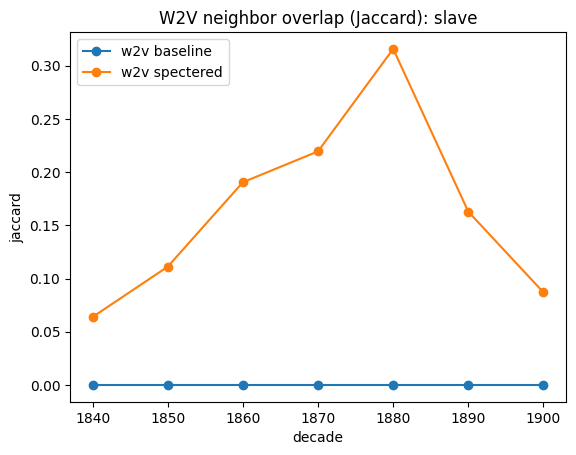

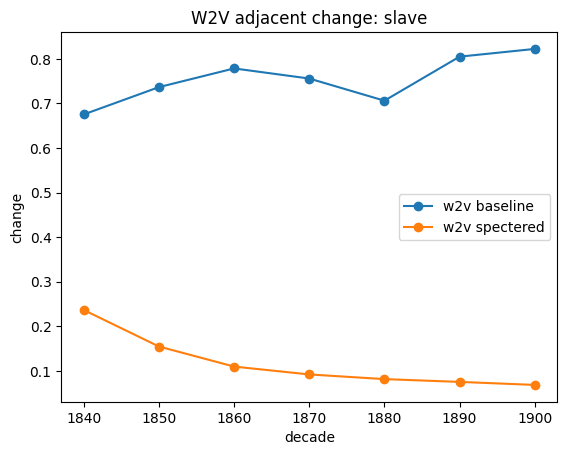


TERM: cotton

W2V baseline neighbors (clean)


,decade,neighbors
0,1830,"consenting, sheriffs, vice-president, pocus, vice-presidency, bald-headed, tallow-colored, feeliugs, episcopal, brisker, imitate, teasing"
1,1840,"annually, pods, peas, planted, bales, benefactors, rice, rialto, imported, cottongin, pod, seeds"
2,1850,"home-work, alabam, uncivil, picks, half-yearly, corn-shucking, endicott, codfish, tack, jauntily, ghoul, swill"
3,1860,"export, bales, dons, horse-power, factories, crop, readjusting, slave-ships, puritans, cranium, fabrics, lbs"
4,1870,"breezeless, plomptly, iron-gray, barricade, ashe, cradler, fisk, teamster, pumy, harboring, second-rate, signifying"
5,1880,"aloizg, ern, littleg, bales, diuctum, larceny, weal, spiceries, railroad-track, jerkily, grooves, search-warrant"
6,1890,"pickers, loads, conglomerate, fleece-lined, jobbing, sepia-coloured, crinkle, darkies, hickory-nut, desisting, nonchalence, bowels"
7,1900,"unlighted, recorded, red-clay, vetoed, bales, horny, ginhouse, parenthetically, usher, toughest, roi, sacking"



W2V spectered neighbors (clean)


,decade,neighbors
0,1830,"consenting, sheriffs, vice-president, pocus, vice-presidency, bald-headed, tallow-colored, feeliugs, episcopal, brisker, imitate, teasing"
1,1840,"rice, annually, rialto, peas, pods, pod, gangs, infants, traded, boot-maker, bales, long-staple"
2,1850,"factories, pods, corporation, gangs, hoeing, boarding, whips, crickets, gibberish, inhabiting, tortugas, affable"
3,1860,"factories, horse-power, bale, slave-ships, ninety, rice, whips, oxen, haberdashery, half-suspected, bales, inhabiting"
4,1870,"bale, bales, cooks, oxen, planting, hams, rice, farms, hitting, dry-goods, stuffing, condiment"
5,1880,"bales, bottoms, peeled, scoured, farms, oxen, freshets, hominy, bulrush, greasy, sea-island, corporation"
6,1890,"bales, conglomerate, sacks, loads, jobbing, jugs, pickers, yellowish, bowels, groceries, bottoms, lowlands"
7,1900,"bales, roi, bottoms, smokehouse, southampton, parenthetically, wharves, holstein, hams, cotton-picking, copper, stew"


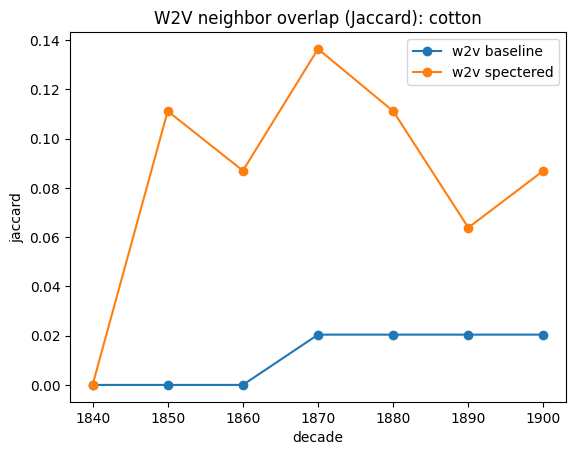

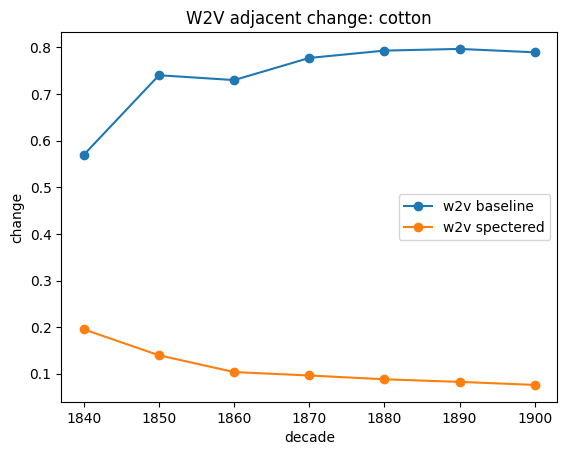


TERM: negro

W2V baseline neighbors (clean)


,decade,neighbors
0,1830,"casion, bery, tan, distory, wuss, unrestrainable, unhesitatingly, complacently, jannet, misshapen, dem, etarnal"
1,1840,"mistresses, duelist, inn, instructs, negroes, presbyterian, eice, inton, auction-store, thereon, extinction, slave-ship"
2,1850,"smut, meliorated, flog, proaching, pennant, cbsely, savior, editorials, highly-scented, hummin, forfeits, palatable"
3,1860,"secessionist, bucksville, clay-eaters, house-keeper, boston-dray, thumb-screw, thunder-storm, negro-quarters, slave-woman, mepherson, amis, cane-fields"
4,1870,"spout, progeny, stable-boys, quitting, yerself, zalea, stalked, pump, prickly, downwards, smart, errand-boy"
5,1880,"rechoes, piscatorial, cornell, befo, nimblest, flips, entry, ferent, carriage-seat, richly-attired, stump-root, georta"
6,1890,"rils, hurrahing, clinton, pro-eminence, agitator, school-teachers, mayors, illhealth, beastly, auctioning, downtrodden, dismissing"
7,1900,"portionately, virtually, folk-lore, inferiority, amalgamation, imperturbable, bondage, satan-forged, educating, race, anglo-saxon, assaulting"



W2V spectered neighbors (clean)


,decade,neighbors
0,1830,"casion, bery, tan, distory, wuss, unrestrainable, unhesitatingly, complacently, jannet, misshapen, dem, etarnal"
1,1840,"emancipating, instructs, negroes, avowing, encourages, mistresses, vesey, submitting, scipio, auction-store, buckrah, traders"
2,1850,"meliorated, negroes, slave-ship, mistresses, traders, cornhill, atrocities, slave-dealers, frugality, hanged, conspiracies, firemen"
3,1860,"blacks, abolishing, productiveness, zanguebar, amis, pride-hating, workee, legree, slave-ship, surliness, clocks, squats"
4,1870,"blacks, jungles, progeny, crows, ethiopian, comfortabler, sile, identification, bloated, black, golly, retaliation"
5,1880,"piscatorial, emerging, superstitions, blacks, houseservant, spatter, quid, georta, dialect, self-seeking, identification, corn-shucking"
6,1890,"slave-ship, blacks, whites, hurrahing, school-teachers, hangers-on, ethiopian, retaliation, gendeman, sisted, tinued, impervious"
7,1900,"race, blacks, whites, convicts, slaveholders, satan-forged, abolitionists, intermarriage, criminals, dens, clother, cranium"


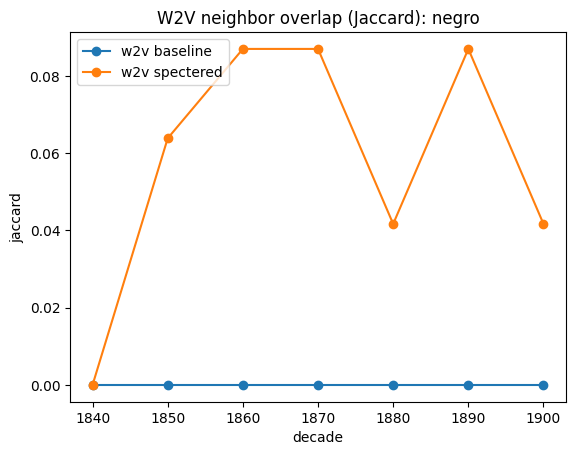

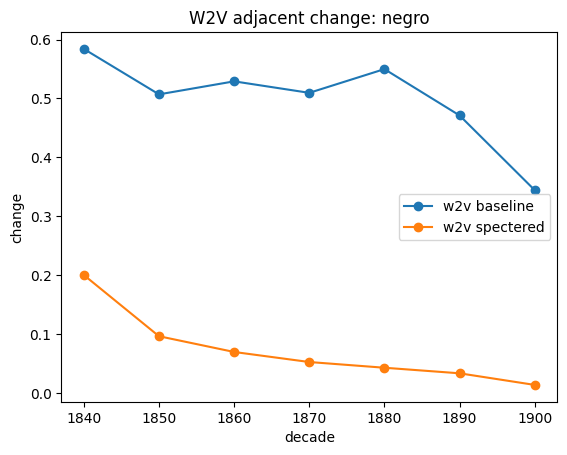

In [10]:
for term in TARGET_WORDS:
    print("\n" + "="*90)
    print("TERM:", term)

    print("\nW2V baseline neighbors (clean)")
    display(neighbor_trail(term, w2v_aligned, k=75, keep_k=12))

    print("\nW2V spectered neighbors (clean)")
    display(neighbor_trail(term, w2v_spectered, k=75, keep_k=12))

    # Quantitative: neighbor overlap
    df_ov_base = neighbor_overlap(term, w2v_aligned, k=100, keep_k=25)
    df_ov_spec = neighbor_overlap(term, w2v_spectered, k=100, keep_k=25)
    plot_two_series(df_ov_base, df_ov_spec, x="decade", y="jaccard",
                    label_a="w2v baseline", label_b="w2v spectered",
                    title=f"W2V neighbor overlap (Jaccard): {term}")

    # Drift plot
    df_drift_base = adjacent_change(term, w2v_aligned)
    df_drift_spec = adjacent_change(term, w2v_spectered)
    plot_two_series(df_drift_base, df_drift_spec, x="decade", y="change",
                    label_a="w2v baseline", label_b="w2v spectered",
                    title=f"W2V adjacent change: {term}")


## 8) Sanity run (recommended)

Run this once. If these look like junk, your issue is upstream (tokenization/OCR/noise), not spectering.

In [11]:
for term in TERM_SETS["sanity_common"]:
    print("\n" + "-"*90)
    print("SANITY TERM:", term)
    display(neighbor_trail(term, w2v_aligned, k=75, keep_k=12))



------------------------------------------------------------------------------------------
SANITY TERM: man


,decade,neighbors
0,1830,"back-bone, spccially, eulogistic, pertinaciously-adhering, blarney, buttermilk, gunshot, killer, geese, sham, sibyl, meek-tempered"
1,1840,"everyday, ill-will, prides, spurned, paternally, ploughline, over-worked, reether, providential, thefts, shoulderstrap, crea"
2,1850,"canse, hemus, adept, set-on, taresses, ginerous, spectatum, dihy, fhc, devourer, concatenation, gubernatorial"
3,1860,"cockerel, top-chief, exeef, assertors, speechifyin, forg, deep-laid, bekase, impov, ablisherner, gurgled, leather-headed"
4,1870,"cations, thunder-cloud, unadjusted, calaboose, premonitory, rope-walk, buckrah, due-bills, soul-refreshing, entretien, bonze, honeycombed"
5,1880,"avay, thunderation, free-and-easy, takings, bahnk, pologize, pancakes, libes, piirsnoir, cogs, lae, erup"
6,1890,"shoe-sole, inheriting, ginerally, gendeman, circuitrider, true-hearted, dashin, re-incarnation, pad, thiow, goodest, tantalized"
7,1900,"mad-lak, teno, idolater, unsecured, sink-hole, wituess, dishcloth, utilised, tripper-business, old-young, comatose, stire"



------------------------------------------------------------------------------------------
SANITY TERM: woman


,decade,neighbors
0,1830,"piide, dential, luke, instinctive, toad, alluding, groggy, tatur, spin, commiseration, henrietta, intreat"
1,1840,"fering, treuman, ambassadress, couchant, intently, oughent, supposin, dressing-case, mortifying, country-house, unshrinkingly, schedule"
2,1850,"onkind, blackguardism, a-saying, a-hugged, coppral, whereber, contradicted, man-body, cleave, mouthe, cousiderin, hamt"
3,1860,"sacredly, wedding-day, youthful-looking, squeamy, spirit-barrels, elf, niobe-mother, stumper, psliaw, extolling, nancc, madeithar"
4,1870,"hem-wm, wretchl, much-injured, death-song, runr, impersonation, freeze, defensive, ves, evert, tyrannous, nonplussed"
5,1880,"certain-surely, unembarrassed, wellguarded, hebby, oft-spurued, rected, classical, punctuality, yqu, siderable, tearlessly, disturbs"
6,1890,"vinculis, spotlessly, outlive, weak-minded, muzzle-downward, unemotional, misjudges, prisms, smooth-spoken, deep-spotted, gentleuian, impervious"
7,1900,"bewilderingly, concentrate, ballrooms, sybarite, elementary, peculiarity, outweighs, epithets, unturned, too-harsh, screwed, uncom"



------------------------------------------------------------------------------------------
SANITY TERM: child


,decade,neighbors
0,1830,"whippy, sitt, doin, cla, rovje, ole, motber, flinched, infants, slut, hussy, nuther"
1,1840,"remodelled, fainter, visibly, moistened, reigned, scold, impetuosity, stirred, joyless, ble, emanation, ambassadress"
2,1850,"preachrrs, capotes, conquering, transfused, prematurely-wise, gavy, vnth, womens, life-bought, perpetrator, falteringly, garet"
3,1860,"lewd, scrub, doated, up-turned, blame-but, croup, ttyhat, bed-clothing, ilobbs, absorbs, cof, coche"
4,1870,"schooling, rotegce, watch-tower, to-nightbut, implant, musicwere, couldst, cherie, voluptuousness, snared, the'jud, falmouth"
5,1880,"intonations, orphanage, antedate, safety-valve, set-back, couching, granc, sendiic, laundresses, a-forgittin, tuought, heaven-sent"
6,1890,"danger-signal, fingernails, bolt-uprightness, mauvaise, crab-apples, bitterer, christianlike, suction, soap-suds, bedewed, drowsy-eyed, ill-humors"
7,1900,"laslt, jong, sehrl, rigors, idols, apprenticed, sentimentally, ballet-dancer, tepees, sorrell, delicately-veined, hard-souled"



------------------------------------------------------------------------------------------
SANITY TERM: house


,decade,neighbors
0,1830,"youngsters, philosophic, pouches, discomfortable, inexperience, ostler, dawned, replenished, generalship, paraphernalia, supine, informing"
1,1840,"shiras, flourishin, plumb, buttonless, dark-blue, buncombe, sidewalks, onwards, ebery, window-frames, tbo, possumhunts"
2,1850,"eoursc, gleasure, fracture, drest, broken-backed, nokes, deputed, unformed, cuddies, stentor-lungs, tincit, lected"
3,1860,"vck, selfdenial, cannot-must, mi-s, whatr, patronising, opiate, ti-ick, fledl, whoopingcough, invohmtary, sandersville"
4,1870,"picayunes, louis-street, pleasant-like, graveyard, barbarians, blinkin, desolations, mistiss, cannot-shot, walkin, vrai, tllat"
5,1880,"week-day, receiver, leastaways, hob-and-nob, stools, vivard, inore, nips, snooze, mistreat, wex, gineration"
6,1890,"weaving-room, booger, spiritualistic, duds, heart-moving, churchgoin, saing, piisoner, upsteairs, nail-heads, pecking, be-u-tiful"
7,1900,"papah, whiteheaded, worthiest, dominance, minutest, jesso, gills, mid-morning, wiglywam, ceiled, supped, nbread"



------------------------------------------------------------------------------------------
SANITY TERM: room


,decade,neighbors
0,1830,"larly, saneric, aggravating, kinder, conver, epicure, accost, dils, rickety, talbot, admonition, unsatisfi"
1,1840,"tea, eech, scampered, stairs, spindle-legged, mod, laconic, reading, lang, jumpin, kanguage, dames"
2,1850,"glorifying, falteringly, onee, reliciof, zue, gath, broom, womens, wax-polished, defection, sition, cooing"
3,1860,"firom, sci, polygamist, swamp-no, stupified, apartment-extending, ayalton, unpolished, oried, vandal, orplian, efiulgence"
4,1870,"sbe, tiring-woman, auntie, whore, a-smelling, tranral, draggled, she-wolves, corrugated, blood-stains, eouldljust, romps"
5,1880,"jflushed, imoyne, rebutting, semi-death, counterparts, apd, dry-eyed, fuchsias, ducted, unrefined, colleague, moai"
6,1890,"dosing, frighteu, dow-sill, maiy, carpentering, ablow, marble-like, startiugly, stag, damper, ious, earth-worn"
7,1900,"saloonkeeper, footstep, crawfords, unbarred, economize, brougham, bookcases, traveller, diggin, gladiators, vials, plished"



------------------------------------------------------------------------------------------
SANITY TERM: work


,decade,neighbors
0,1830,"meritorious, prerogatives, limiting, treed, hairs, absurdity, crelur, tying, outlying, consarn, stealth, magnanimity"
1,1840,"blesses, footmen, acting-manager, livery, executing, isay, trainer, trainings, performs, slaveholder, athentbum, governmental"
2,1850,"pigstye, reasoner, robust-looking, plough-boy, larning, house-building, brini, complainin, lifev, popu, uncls, house-wifery"
3,1860,"blacks-but, cincinnatus, art-studies, adults, indexing, unquestioning, apologists, rum-stills, factory-girls, uninured, fire-wood, progeny"
4,1870,"employers, promptly-and, examiner, ninth, withholds, linnrcus, unraveled, hervery, chipped, muttons, spoiler, lter"
5,1880,"growlingly, djd, insincere, referee, money-sense, er-showiu, yarth, fhem, flog, discriminated, generative, medallion"
6,1890,"njind, great-sized, gomorrah, easylike, icry, obliterate, blushingly, ayayc, sofshell, abduction, boyle, esater"
7,1900,"midly, headline, long-vacant, alarmingly, book-learnin, noised, faultlessly, dashy, flatirons, gut, swearin, dishcloth"



------------------------------------------------------------------------------------------
SANITY TERM: money


,decade,neighbors
0,1830,"strikers, blackleg, psha, slitting, dine, suck, claps, right-down, kichard, henchman, raisin, slenderer"
1,1840,"fines, bought, harvard, freedonian, purses, loan, to-a, steamboatlines, wiggins, ofyou, wheat, saddel"
2,1850,"comeoff, driblets, scald, rye, riirht, votre, ragan, crickets, rafe, voucher, avanity, yine"
3,1860,"iltbrarg, fines, tial, contemptuons, bought, windbroken, ize, chany, chargine, coarsest, a-laying, renewred"
4,1870,"mysterieuze, noteshaver, gang-plank, winnin, conscien, soupspicion, miserabl, ged, spishun, dyker, ten-foot, perfession"
5,1880,"dreckly, clinkalinkle, grope, clink, booger, tinbox, jeopardizes, ilibrarg, moneyed, clinkalink, rouncl, flinders"
6,1890,"dewberries, naine, squaw-mother, distrib, woun, confederick, misterust, olt, avagons, ever-slipping, a-told, he-se"
7,1900,"ignunt, bobbin, ogletharp, furthermo, harry-dick, insinivated, realizin, collateral, hitches, cusin, anybodycan, argify"



------------------------------------------------------------------------------------------
SANITY TERM: horse


,decade,neighbors
0,1830,"shoe, greenwood, gallop, consara, guerre, shoe-leather, huzza, inroad, affirms, hoot, freebooter, thasecond"
1,1840,"intersected, saddle, thorny, lois, unquestioningly, a-travelling, sandy-haired, unquiet, foresaw, letting, half-famished, retrick"
2,1850,"undistinguishable, coatskirts, conglomerated, drip, reining, diggs, jined, swindled, moutbe, mazeppa, honeyed, chaise"
3,1860,"spurs, remounted, arab, pelting, saddle, reined, saddle-horses, bridle-path, firefly, vrilloavbank, field-work, imcle"
4,1870,"pikes, combatants, trains, stirrup, neighing, riders, superbly-framed, menaced, musquetoons, parliamentarians, well-doing, tot"
5,1880,"rider, strides, plugged, horsewoman, trough, limbed, communitjr, diagonal, a-medjurin, moth, slacken, clun"
6,1890,"rangy, rein, maule, lather, hootings, side-door, countersign, shur, crossroad, reer, collar-bone, dau"
7,1900,"rider, past-master, jumper, ashland, medium-sized, tightening, um-um-hm, trainer, babel, leamington, ies, sinew"
